In [1]:
# 分析时间：2013年1月1日-2022年12月31日，总共10年时间
# 但是在做特征分析的时候，可以把数据拉长。多搞一年：即2012-01-01至2022-12-31
feature_start_date_str = "2011-01-01"
start_date_str = "2012-01-01"
end_date_str = "2022-12-31"

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import QuantLib as ql
%matplotlib inline

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [3]:
def clean_data(raw_df, date_benchmark, feature_start_date, end_date):
    clean_df = raw_df[(raw_df['Date']>=feature_start_date) & (raw_df['Date']<=end_date)].reset_index(drop=True)
    investment_fac_df = pd.merge(date_benchmark, clean_df, on="Date", how="left")
    # 采用向下填充
    clean_df = clean_df.fillna(method='ffill')
    return clean_df

def plot_features(clean_df, col_name_list, title="Investment in fixed assets completed"):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for temp_col in col_name_list:
        ax.plot(clean_df['Date'], clean_df[temp_col], label=temp_col)
        

    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    fig.autofmt_xdate()
    plt.tight_layout()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [4]:
feature_start_date = datetime.datetime.strptime(feature_start_date_str, "%Y-%m-%d")
start_date = datetime.datetime.strptime(start_date_str, "%Y-%m-%d")
end_date = datetime.datetime.strptime(end_date_str, "%Y-%m-%d")
print(feature_start_date, start_date, end_date)

2011-01-01 00:00:00 2012-01-01 00:00:00 2022-12-31 00:00:00


In [5]:
# 取出目标数据
# 到期收益率
raw_yield_to_maturity_df = pd.read_excel('./data/国债到期收益率.xlsx')
raw_yield_to_maturity_df = raw_yield_to_maturity_df.rename(columns={'指标名称': 'Date',
       '国债到期收益率:6个月': "6M", '国债到期收益率:1年': "1Y", '国债到期收益率:2年': "2Y", '国债到期收益率:3年': "3Y",
       '国债到期收益率:4年': "4Y", '国债到期收益率:5年': "5Y", '国债到期收益率:6年': "6Y", '国债到期收益率:7年': "7Y", 
        '国债到期收益率:8年': "8Y",'国债到期收益率:9年': "9Y", '国债到期收益率:10年': "10Y", '国债到期收益率:15年': "15Y", 
        '国债到期收益率:20年': "20Y", '国债到期收益率:30年': "30Y"})
raw_yield_to_maturity_df

,Date,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,30Y
0,2008-07-01,3.2769,3.4474,3.8065,4.0301,4.1697,4.3093,4.3498,4.3903,4.4292,4.4682,4.5072,4.9618,4.9639,4.9498
1,2008-07-02,3.4055,3.5461,3.8015,3.9506,4.0883,4.2260,4.3019,4.3778,4.4282,4.4787,4.5291,4.9442,4.9462,4.9501
2,2008-07-03,3.3343,3.4972,3.8687,3.9820,4.1085,4.2350,4.3163,4.3976,4.4436,4.4896,4.5356,4.9453,4.9469,4.9501
3,2008-07-04,3.3397,3.4763,3.8179,3.9854,4.1031,4.2209,4.3183,4.4157,4.4618,4.5080,4.5542,4.9469,4.9479,4.9501
4,2008-07-07,3.3679,3.4796,3.8138,3.9561,4.0850,4.2140,4.2849,4.3559,4.4215,4.4871,4.5527,4.9226,4.9285,4.9404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,2023-03-13,2.1958,2.2696,2.4373,2.5289,2.6127,2.6965,2.7655,2.8345,2.8473,2.8600,2.8728,3.0310,3.1147,3.2772
3668,2023-03-14,2.1950,2.2655,2.4475,2.5215,2.6046,2.6877,2.7591,2.8305,2.8417,2.8528,2.8640,3.0196,3.1047,3.2692
3669,2023-03-15,2.2050,2.2638,2.4432,2.5278,2.6121,2.6963,2.7663,2.8363,2.8474,2.8584,2.8695,3.0152,3.1033,3.2700
3670,2023-03-16,2.1799,2.2598,2.4193,2.5182,2.5953,2.6723,2.7483,2.8242,2.8342,2.8441,2.8541,2.9998,3.0857,3.2503


In [6]:
# 按特征长度选择数据
yield_to_maturity_df = raw_yield_to_maturity_df[(raw_yield_to_maturity_df['Date']>=feature_start_date)
                                                & (raw_yield_to_maturity_df['Date']<=end_date)].reset_index(drop=True)
yield_to_maturity_df

,Date,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,30Y
0,2011-01-04,2.9635,3.0310,3.3571,3.3839,3.4591,3.5343,3.6066,3.6790,3.7370,3.7951,3.8531,4.0629,4.1640,4.2839
1,2011-01-05,2.9262,3.0047,3.1834,3.2891,3.3696,3.4500,3.5466,3.6432,3.6993,3.7553,3.8113,4.0108,4.1683,4.2554
2,2011-01-06,2.6401,2.8361,3.1205,3.2438,3.3567,3.4696,3.5691,3.6686,3.7146,3.7607,3.8067,4.0104,4.1645,4.2528
3,2011-01-07,2.6055,2.7599,3.1324,3.3165,3.3916,3.4667,3.5586,3.6505,3.7163,3.7820,3.8478,4.0208,4.1638,4.2649
4,2011-01-10,2.5607,2.7767,3.0750,3.2557,3.3469,3.4381,3.5293,3.6205,3.6891,3.7578,3.8264,4.0104,4.1569,4.2575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,2022-12-26,2.1778,2.2398,2.3669,2.4616,2.5396,2.6175,2.7175,2.8175,2.8249,2.8324,2.8398,2.9777,3.0579,3.2225
2989,2022-12-27,2.2125,2.2615,2.3889,2.4898,2.5777,2.6656,2.7526,2.8395,2.8475,2.8556,2.8636,3.0014,3.0676,3.2182
2990,2022-12-28,2.2398,2.2732,2.4056,2.4746,2.5771,2.6795,2.7595,2.8395,2.8496,2.8598,2.8699,3.0078,3.0679,3.2125
2991,2022-12-29,2.1737,2.1952,2.3605,2.4405,2.5415,2.6425,2.7314,2.8202,2.8255,2.8309,2.8362,2.9741,3.0459,3.2021


In [7]:
date_benchmark = yield_to_maturity_df[["Date"]]
date_benchmark

,Date
0,2011-01-04
1,2011-01-05
2,2011-01-06
3,2011-01-07
4,2011-01-10
...,...
2988,2022-12-26
2989,2022-12-27
2990,2022-12-28
2991,2022-12-29


### 美国国债到期收益率

USA Treasury yield to maturity

In [8]:
raw_usa_bond_df = pd.read_excel("./data/features/美国国债到期收益率.xlsx")
raw_usa_bond_df = raw_usa_bond_df.rename(columns={
    '指标名称': "Date", '美国:国债到期收益率:1个月': "USA_Bond_1M", '美国:国债到期收益率:3个月': "USA_Bond_3M", 
    '美国:国债到期收益率:6个月': "USA_Bond_6M",'美国:国债到期收益率:1年': "USA_Bond_1Y", 
    '美国:国债到期收益率:2年': "USA_Bond_2Y", '美国:国债到期收益率:3年': "USA_Bond_3Y", '美国:国债到期收益率:5年': "USA_Bond_5Y",
       '美国:国债到期收益率:7年': "USA_Bond_7Y", 
    '美国:国债到期收益率:10年': "USA_Bond_10Y", '美国:国债到期收益率:20年': "USA_Bond_20Y", '美国:国债到期收益率:30年': "USA_Bond_30Y"
})
raw_usa_bond_df

,Date,USA_Bond_1M,USA_Bond_3M,USA_Bond_6M,USA_Bond_1Y,USA_Bond_2Y,USA_Bond_3Y,USA_Bond_5Y,USA_Bond_7Y,USA_Bond_10Y,USA_Bond_20Y,USA_Bond_30Y
0,1953-04-30,NaN,NaN,NaN,2.36,NaN,2.51,2.62,NaN,2.83,3.08,NaN
1,1953-05-31,NaN,NaN,NaN,2.48,NaN,2.72,2.87,NaN,3.05,3.18,NaN
2,1953-06-30,NaN,NaN,NaN,2.45,NaN,2.74,2.94,NaN,3.11,3.21,NaN
3,1953-07-31,NaN,NaN,NaN,2.38,NaN,2.62,2.75,NaN,2.93,3.12,NaN
4,1953-08-31,NaN,NaN,NaN,2.28,NaN,2.58,2.80,NaN,2.95,3.10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
15386,2023-03-10,4.81,5.01,5.17,4.90,4.60,4.31,3.96,3.86,3.70,3.90,3.70
15387,2023-03-13,4.62,4.87,4.81,4.30,4.03,3.88,3.68,3.65,3.55,3.85,3.70
15388,2023-03-14,4.47,4.88,4.93,4.45,4.20,4.05,3.78,3.74,3.64,3.91,3.77
15389,2023-03-15,4.23,4.75,4.73,4.19,3.93,3.83,3.59,3.57,3.51,3.82,3.70


In [9]:
usa_bond_df = clean_data(raw_usa_bond_df, date_benchmark, feature_start_date, end_date)
usa_bond_df

,Date,USA_Bond_1M,USA_Bond_3M,USA_Bond_6M,USA_Bond_1Y,USA_Bond_2Y,USA_Bond_3Y,USA_Bond_5Y,USA_Bond_7Y,USA_Bond_10Y,USA_Bond_20Y,USA_Bond_30Y
0,2011-01-03,0.11,0.15,0.19,0.29,0.61,1.03,2.02,2.74,3.36,4.18,4.39
1,2011-01-04,0.12,0.14,0.19,0.28,0.63,1.04,2.01,2.72,3.36,4.21,4.44
2,2011-01-05,0.13,0.14,0.19,0.31,0.71,1.16,2.14,2.86,3.50,4.34,4.55
3,2011-01-06,0.13,0.15,0.18,0.30,0.68,1.11,2.09,2.80,3.44,4.31,4.53
4,2011-01-07,0.13,0.14,0.18,0.29,0.60,1.02,1.96,2.69,3.34,4.25,4.48
...,...,...,...,...,...,...,...,...,...,...,...,...
2996,2022-12-23,3.80,4.34,4.67,4.66,4.31,4.09,3.86,3.83,3.75,3.99,3.82
2997,2022-12-27,3.87,4.46,4.76,4.75,4.32,4.17,3.94,3.93,3.84,4.10,3.93
2998,2022-12-28,3.86,4.46,4.75,4.71,4.31,4.18,3.97,3.97,3.88,4.13,3.98
2999,2022-12-29,4.04,4.45,4.73,4.71,4.34,4.16,3.94,3.91,3.83,4.09,3.92


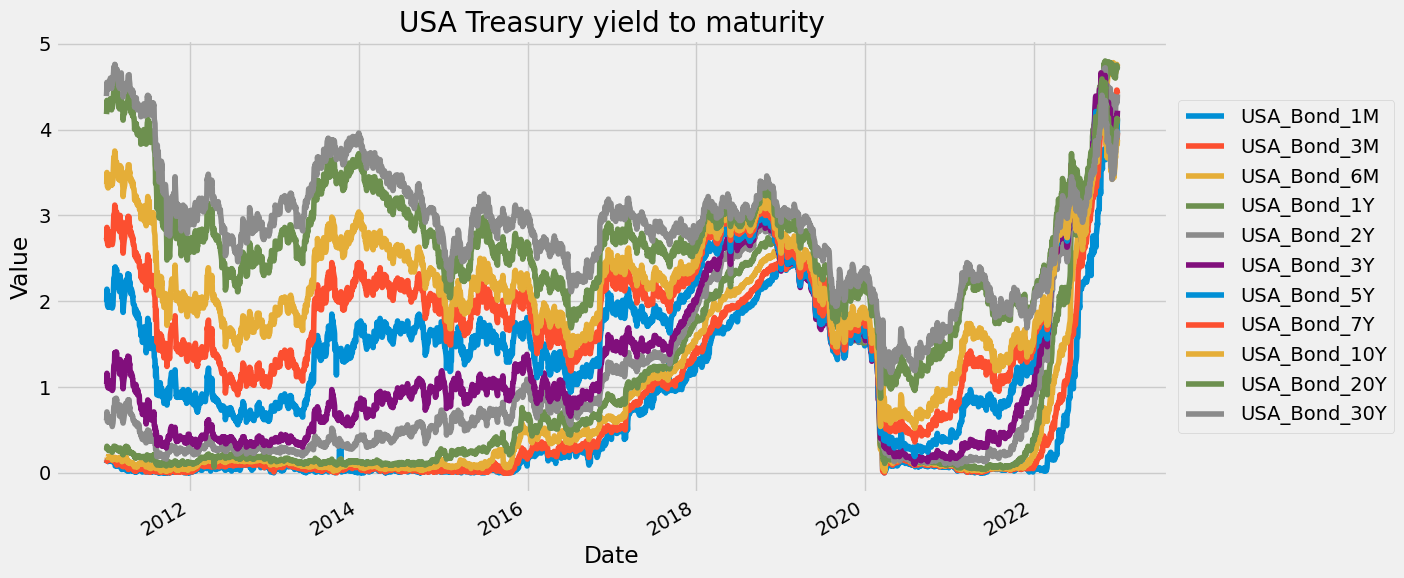

In [10]:
plot_features(usa_bond_df, ['USA_Bond_1M', 'USA_Bond_3M', 'USA_Bond_6M', 'USA_Bond_1Y',
       'USA_Bond_2Y', 'USA_Bond_3Y', 'USA_Bond_5Y', 'USA_Bond_7Y',
       'USA_Bond_10Y', 'USA_Bond_20Y', 'USA_Bond_30Y'], title="USA Treasury yield to maturity")

### 汇率
exchange rate

In [11]:
raw_exchange_rate_df = pd.read_excel("./data/features/人民币汇率(日).xlsx")
raw_exchange_rate_df = raw_exchange_rate_df.rename(columns={
    '指标名称': "Date", '中国:中间价:美元兑人民币': "USA_RMB"
})
raw_exchange_rate_df

,Date,USA_RMB
0,1994-08-31,8.5616
1,1994-09-01,8.5591
2,1994-09-02,8.5565
3,1994-09-05,8.5540
4,1994-09-06,8.5511
...,...,...
6999,2023-03-13,6.9375
7000,2023-03-14,6.8949
7001,2023-03-15,6.8680
7002,2023-03-16,6.9149


In [12]:
exchange_rate_df = clean_data(raw_exchange_rate_df, date_benchmark, feature_start_date, end_date)
exchange_rate_df

,Date,USA_RMB
0,2011-01-04,6.6215
1,2011-01-05,6.6295
2,2011-01-06,6.6322
3,2011-01-07,6.6341
4,2011-01-10,6.6349
...,...,...
2912,2022-12-26,6.9825
2913,2022-12-27,6.9546
2914,2022-12-28,6.9681
2915,2022-12-29,6.9793


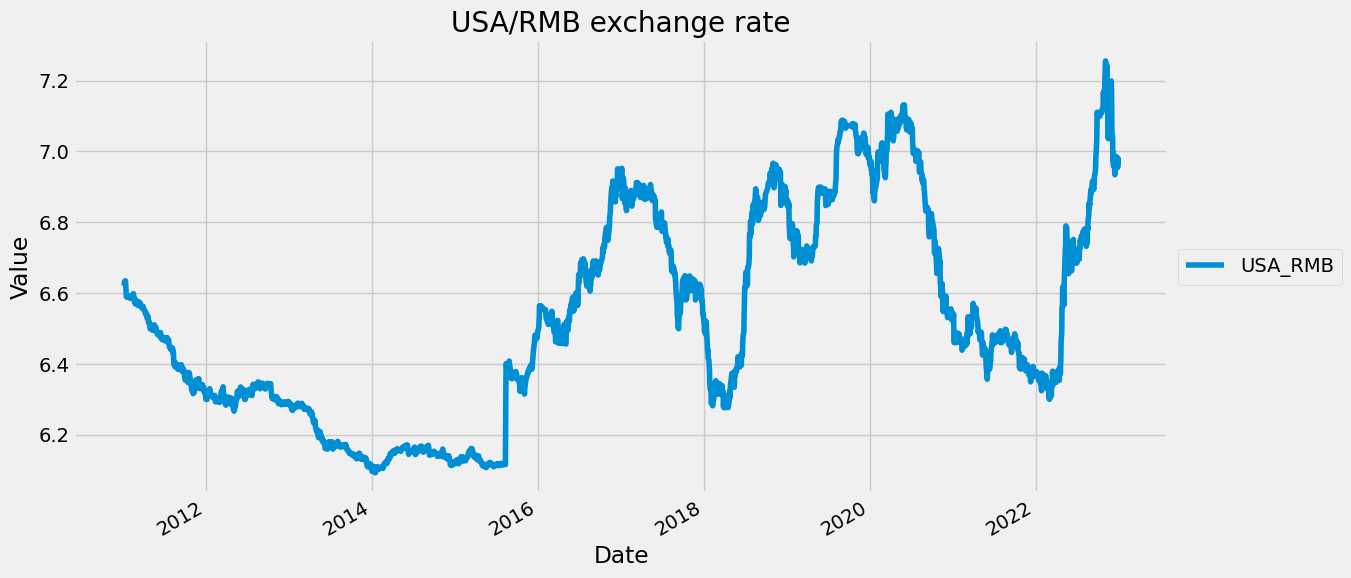

In [13]:
plot_features(exchange_rate_df, ['USA_RMB'], title="USA/RMB exchange rate")

### 人民币固定利率对美元Libor3M

The fixed rate of RMB is Libor3M against the dollar

In [14]:
raw_fixed_rmb_libor_3m_df = pd.read_excel("./data/features/人民币固定利率对美元Libor3M.xlsx")
raw_fixed_rmb_libor_3m_df = raw_fixed_rmb_libor_3m_df.rename(columns={
    '指标名称': 'Date', '人民币固定利率对美元Libor3M_均值:1Y': "Fixed_Libor3M_1Y", 
    '人民币固定利率对美元Libor3M_均值:2Y': "Fixed_Libor3M_2Y",
       '人民币固定利率对美元Libor3M_均值:3Y': "Fixed_Libor3M_3Y", '人民币固定利率对美元Libor3M_均值:4Y': "Fixed_Libor3M_4Y",
       '人民币固定利率对美元Libor3M_均值:5Y': "Fixed_Libor3M_5Y"
})
raw_fixed_rmb_libor_3m_df

,Date,Fixed_Libor3M_1Y,Fixed_Libor3M_2Y,Fixed_Libor3M_3Y,Fixed_Libor3M_4Y,Fixed_Libor3M_5Y
0,2013-01-21,1.88,1.82,1.96,2.09,2.24
1,2013-01-22,1.88,1.81,1.99,2.13,2.27
2,2013-01-23,1.92,1.82,1.96,2.08,2.23
3,2013-01-24,1.96,1.84,1.94,2.06,2.22
4,2013-01-25,1.99,1.88,1.94,2.10,2.29
...,...,...,...,...,...,...
2458,2023-03-13,2.80,3.00,3.00,3.10,3.10
2459,2023-03-14,2.80,3.00,3.00,3.10,3.10
2460,2023-03-15,2.80,3.00,3.00,3.10,3.10
2461,2023-03-16,2.80,3.00,3.00,3.10,3.10


In [15]:
fixed_rmb_libor_3m_df = clean_data(raw_fixed_rmb_libor_3m_df, date_benchmark, feature_start_date, end_date)
fixed_rmb_libor_3m_df

,Date,Fixed_Libor3M_1Y,Fixed_Libor3M_2Y,Fixed_Libor3M_3Y,Fixed_Libor3M_4Y,Fixed_Libor3M_5Y
0,2013-01-21,1.88,1.82,1.96,2.09,2.24
1,2013-01-22,1.88,1.81,1.99,2.13,2.27
2,2013-01-23,1.92,1.82,1.96,2.08,2.23
3,2013-01-24,1.96,1.84,1.94,2.06,2.22
4,2013-01-25,1.99,1.88,1.94,2.10,2.29
...,...,...,...,...,...,...
2409,2022-12-26,2.00,2.15,2.30,2.30,2.00
2410,2022-12-27,2.00,2.15,2.30,2.30,2.00
2411,2022-12-28,2.48,2.78,2.88,2.35,2.00
2412,2022-12-29,2.29,2.78,2.98,2.30,2.00


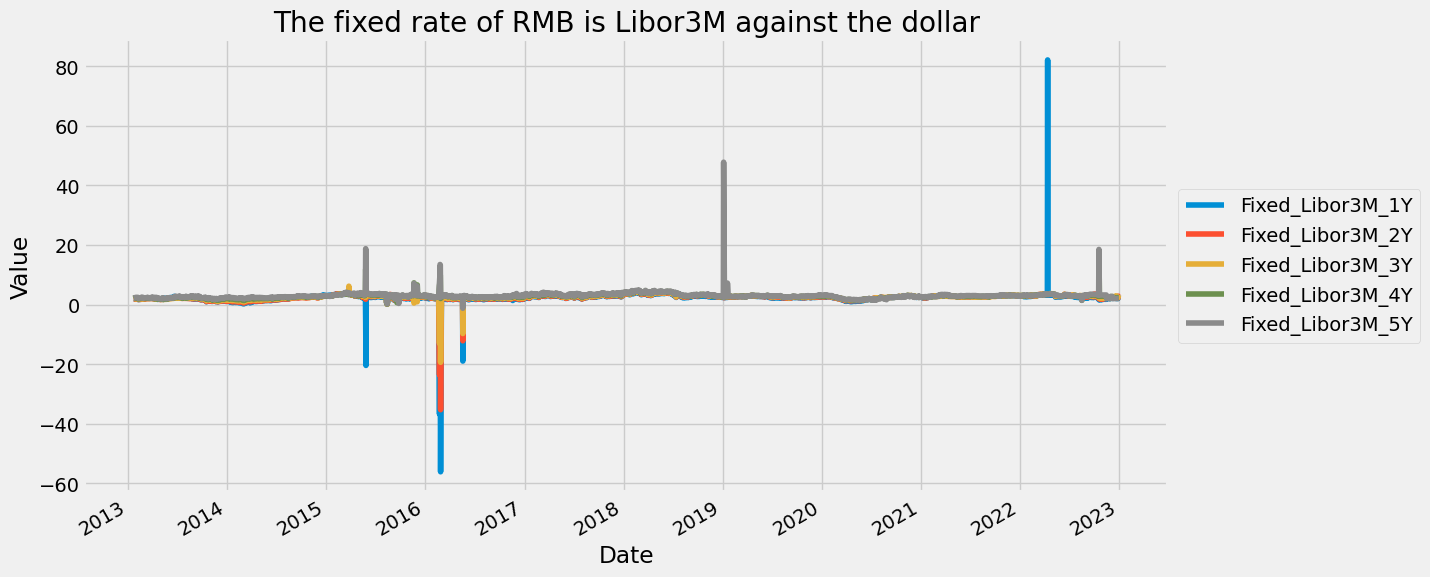

In [16]:
plot_features(fixed_rmb_libor_3m_df, ['Fixed_Libor3M_1Y', 'Fixed_Libor3M_2Y', 'Fixed_Libor3M_3Y',
       'Fixed_Libor3M_4Y', 'Fixed_Libor3M_5Y'], title="The fixed rate of RMB is Libor3M against the dollar")

### 人民币Shibor3M对美元Libor3M

RMB Shibor3M to dollar Libor3M 

In [17]:
raw_shibor3m_libor3m_df = pd.read_excel("./data/features/人民币Shibor3M对美元Libor3M.xlsx")
raw_shibor3m_libor3m_df = raw_shibor3m_libor3m_df.rename(columns={
    '指标名称': 'Date', '人民币Shibor3M对美元Libor3M_均值:1Y': "Shibor3M_Libor3M_1Y", 
    '人民币Shibor3M对美元Libor3M_均值:2Y': "Shibor3M_Libor3M_2Y",
       '人民币Shibor3M对美元Libor3M_均值:3Y': "Shibor3M_Libor3M_3Y", 
    '人民币Shibor3M对美元Libor3M_均值:4Y': "Shibor3M_Libor3M_4Y",
       '人民币Shibor3M对美元Libor3M_均值:5Y': "Shibor3M_Libor3M_5Y"
})
raw_shibor3m_libor3m_df

,Date,Shibor3M_Libor3M_1Y,Shibor3M_Libor3M_2Y,Shibor3M_Libor3M_3Y,Shibor3M_Libor3M_4Y,Shibor3M_Libor3M_5Y
0,2013-01-21,-1.9786,-2.0607,-1.9879,-1.9158,-1.7925
1,2013-01-22,-2.0067,-2.0858,-1.9942,-1.8950,-1.8070
2,2013-01-23,-1.9621,-2.0907,-2.0164,-1.9458,-1.8883
3,2013-01-24,-1.8714,-2.0400,-2.0464,-1.9642,-1.8608
4,2013-01-25,-1.7921,-1.9979,-2.0079,-1.9175,-1.8083
...,...,...,...,...,...,...
2458,2023-03-13,0.1388,0.1405,0.0163,-0.0500,-0.2000
2459,2023-03-14,0.0255,0.0300,0.0320,-0.0500,-0.2000
2460,2023-03-15,0.0260,0.0275,0.0275,-0.0500,-0.2000
2461,2023-03-16,0.0260,0.0275,0.0275,-0.0500,-0.2000


In [18]:
shibor3m_libor3m_df = clean_data(raw_shibor3m_libor3m_df, date_benchmark, feature_start_date, end_date)
shibor3m_libor3m_df

,Date,Shibor3M_Libor3M_1Y,Shibor3M_Libor3M_2Y,Shibor3M_Libor3M_3Y,Shibor3M_Libor3M_4Y,Shibor3M_Libor3M_5Y
0,2013-01-21,-1.9786,-2.0607,-1.9879,-1.9158,-1.7925
1,2013-01-22,-2.0067,-2.0858,-1.9942,-1.8950,-1.8070
2,2013-01-23,-1.9621,-2.0907,-2.0164,-1.9458,-1.8883
3,2013-01-24,-1.8714,-2.0400,-2.0464,-1.9642,-1.8608
4,2013-01-25,-1.7921,-1.9979,-2.0079,-1.9175,-1.8083
...,...,...,...,...,...,...
2409,2022-12-26,0.4000,0.5000,0.5000,0.7000,1.1500
2410,2022-12-27,0.4000,0.5000,0.5000,0.7000,1.1500
2411,2022-12-28,0.4000,0.5000,0.5000,0.7000,1.1500
2412,2022-12-29,0.4000,0.5000,0.5000,0.7000,1.1500


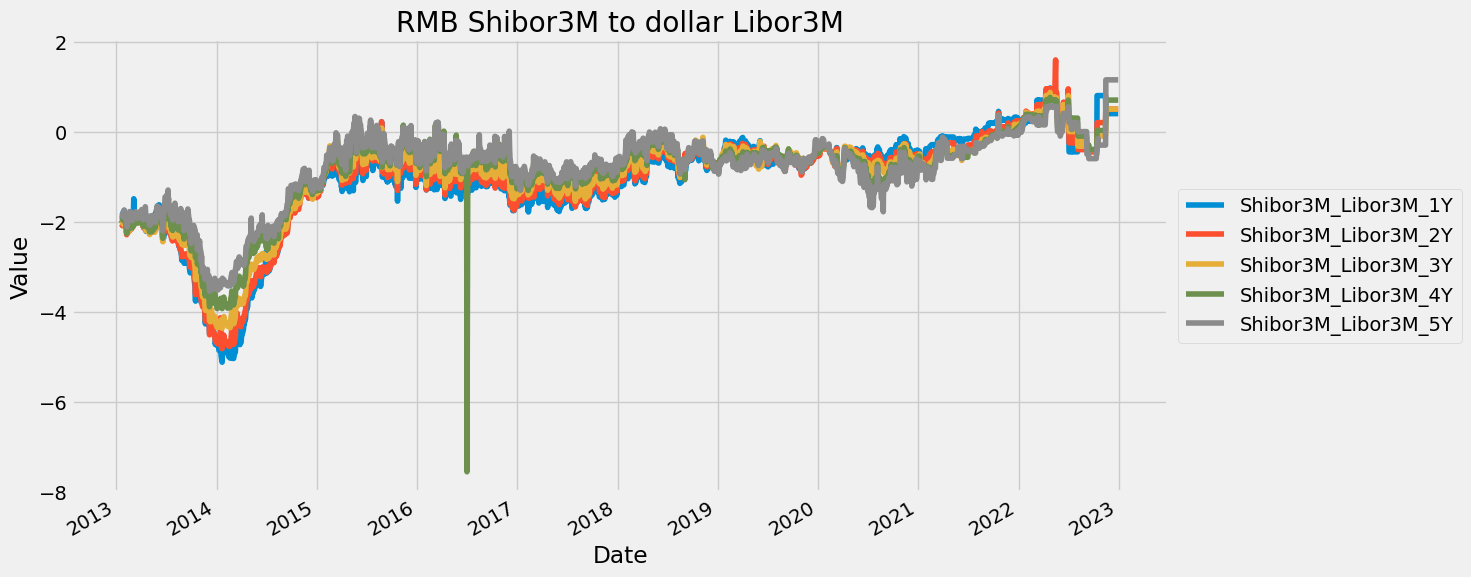

In [19]:
plot_features(shibor3m_libor3m_df, ['Shibor3M_Libor3M_1Y', 'Shibor3M_Libor3M_2Y',
       'Shibor3M_Libor3M_3Y', 'Shibor3M_Libor3M_4Y', 'Shibor3M_Libor3M_5Y'], title="RMB Shibor3M to dollar Libor3M")

### LIBOR



In [20]:
raw_libor_df = pd.read_excel("./data/features/LIBOR.xlsx")
raw_libor_df = raw_libor_df.rename(columns={
    '指标名称': "Date", '美元LIBORO/N': "LIBORO/N", '美元LIBOR1W': "LIBOR1W", '美元LIBOR1M': "LIBOR1M", 
    '美元LIBOR2M': "LIBOR2M",
       '美元LIBOR3M': "LIBOR3M", '美元LIBOR6M': "LIBOR6M", '美元LIBOR12M': "LIBOR12M"
})
raw_libor_df

,Date,LIBORO/N,LIBOR1W,LIBOR1M,LIBOR2M,LIBOR3M,LIBOR6M,LIBOR12M
0,1986-01-02,NaN,NaN,8.12500,NaN,8.00000,8.00000,8.06250
1,1986-01-03,NaN,NaN,8.12500,NaN,8.06250,8.06250,8.12500
2,1986-01-06,NaN,NaN,8.18750,NaN,8.12500,8.12500,8.12500
3,1986-01-07,NaN,NaN,8.12500,NaN,8.12500,8.12500,8.12500
4,1986-01-08,NaN,NaN,8.00000,NaN,8.00000,8.00000,8.06250
...,...,...,...,...,...,...,...,...
9402,2023-03-10,4.55714,NaN,4.79857,NaN,5.13814,5.42829,5.73814
9403,2023-03-13,4.55600,NaN,4.68443,NaN,4.86629,5.05071,5.14257
9404,2023-03-14,4.55357,NaN,4.72771,NaN,4.94100,4.96843,4.99229
9405,2023-03-15,4.55971,NaN,4.70857,NaN,4.90714,4.83400,4.72843


In [21]:
libor_df = clean_data(raw_libor_df, date_benchmark, feature_start_date, end_date)
libor_df

,Date,LIBORO/N,LIBOR1W,LIBOR1M,LIBOR2M,LIBOR3M,LIBOR6M,LIBOR12M
0,2011-01-04,0.24688,0.25438,0.26063,0.2825,0.30281,0.45581,0.78094
1,2011-01-05,0.24375,0.25438,0.26125,0.2825,0.30281,0.45456,0.78094
2,2011-01-06,0.24375,0.25438,0.26125,0.2825,0.30313,0.45719,0.78525
3,2011-01-07,0.24125,0.25438,0.26125,0.2825,0.30313,0.45731,0.78550
4,2011-01-10,0.24125,0.25438,0.26125,0.2825,0.30313,0.45706,0.78400
...,...,...,...,...,...,...,...,...
3025,2022-12-22,4.31500,0.07638,4.38871,0.1525,4.72386,5.14857,5.41586
3026,2022-12-23,4.31671,0.07638,4.38686,0.1525,4.72643,5.15314,5.44386
3027,2022-12-28,4.31643,0.07638,4.38357,0.1525,4.72986,5.15114,5.47029
3028,2022-12-29,4.31186,0.07638,4.36871,0.1525,4.75386,5.13757,5.44257


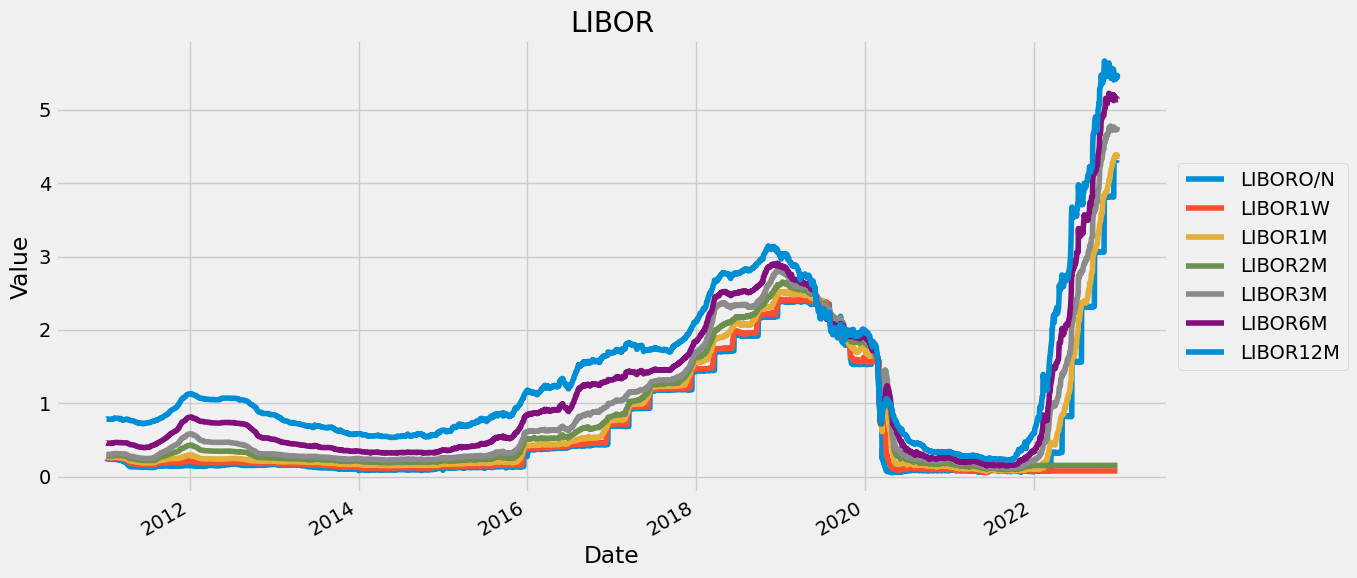

In [22]:
plot_features(libor_df, ['LIBORO/N', 'LIBOR1W', 'LIBOR1M', 'LIBOR2M', 'LIBOR3M',
       'LIBOR6M', 'LIBOR12M'], title="LIBOR")

In [23]:
#Monetary and fiscal policy
result_df = date_benchmark

data_frames = [usa_bond_df, exchange_rate_df, fixed_rmb_libor_3m_df,
                shibor3m_libor3m_df, libor_df]
for temp in data_frames:
    result_df = result_df.merge(temp, on="Date", how="left")
result_df

,Date,USA_Bond_1M,USA_Bond_3M,USA_Bond_6M,USA_Bond_1Y,USA_Bond_2Y,USA_Bond_3Y,USA_Bond_5Y,USA_Bond_7Y,USA_Bond_10Y,...,Shibor3M_Libor3M_3Y,Shibor3M_Libor3M_4Y,Shibor3M_Libor3M_5Y,LIBORO/N,LIBOR1W,LIBOR1M,LIBOR2M,LIBOR3M,LIBOR6M,LIBOR12M
0,2011-01-04,0.12,0.14,0.19,0.28,0.63,1.04,2.01,2.72,3.36,...,NaN,NaN,NaN,0.24688,0.25438,0.26063,0.2825,0.30281,0.45581,0.78094
1,2011-01-05,0.13,0.14,0.19,0.31,0.71,1.16,2.14,2.86,3.50,...,NaN,NaN,NaN,0.24375,0.25438,0.26125,0.2825,0.30281,0.45456,0.78094
2,2011-01-06,0.13,0.15,0.18,0.30,0.68,1.11,2.09,2.80,3.44,...,NaN,NaN,NaN,0.24375,0.25438,0.26125,0.2825,0.30313,0.45719,0.78525
3,2011-01-07,0.13,0.14,0.18,0.29,0.60,1.02,1.96,2.69,3.34,...,NaN,NaN,NaN,0.24125,0.25438,0.26125,0.2825,0.30313,0.45731,0.78550
4,2011-01-10,0.14,0.15,0.18,0.29,0.59,0.99,1.93,2.65,3.32,...,NaN,NaN,NaN,0.24125,0.25438,0.26125,0.2825,0.30313,0.45706,0.78400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,2022-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.5,0.7,1.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2989,2022-12-27,3.87,4.46,4.76,4.75,4.32,4.17,3.94,3.93,3.84,...,0.5,0.7,1.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2990,2022-12-28,3.86,4.46,4.75,4.71,4.31,4.18,3.97,3.97,3.88,...,0.5,0.7,1.15,4.31643,0.07638,4.38357,0.1525,4.72986,5.15114,5.47029
2991,2022-12-29,4.04,4.45,4.73,4.71,4.34,4.16,3.94,3.91,3.83,...,0.5,0.7,1.15,4.31186,0.07638,4.36871,0.1525,4.75386,5.13757,5.44257


In [24]:
result_df.to_csv("./data/clean_features/features_international_market.csv", index=False, encoding="utf-8-sig")

In [25]:
result_df.describe()

,USA_Bond_1M,USA_Bond_3M,USA_Bond_6M,USA_Bond_1Y,USA_Bond_2Y,USA_Bond_3Y,USA_Bond_5Y,USA_Bond_7Y,USA_Bond_10Y,USA_Bond_20Y,...,Shibor3M_Libor3M_3Y,Shibor3M_Libor3M_4Y,Shibor3M_Libor3M_5Y,LIBORO/N,LIBOR1W,LIBOR1M,LIBOR2M,LIBOR3M,LIBOR6M,LIBOR12M
count,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,...,2414.000000,2414.000000,2414.000000,2837.000000,2837.000000,2837.00000,2837.000000,2837.00000,2837.000000,2837.000000
mean,0.614729,0.679079,0.775879,0.868611,1.047307,1.223871,1.581111,1.897464,2.176021,2.650132,...,-0.962182,-0.863720,-0.796384,0.685744,0.579428,0.78490,0.695925,0.95481,1.127287,1.387278
std,0.902669,0.969668,1.029680,1.048105,0.992537,0.931174,0.803260,0.730735,0.691947,0.702031,...,1.001835,0.925373,0.833574,0.873826,0.729329,0.91179,0.760929,0.98963,1.035740,1.072851
min,0.000000,0.000000,0.020000,0.040000,0.090000,0.100000,0.190000,0.360000,0.520000,0.870000,...,-4.370000,-7.556700,-3.545700,0.050750,0.057880,0.07263,0.092630,0.11413,0.146630,0.219500
25%,0.030000,0.050000,0.080000,0.130000,0.290000,0.430000,0.900000,1.390000,1.740000,2.220000,...,-1.204250,-1.056475,-1.023675,0.102500,0.120400,0.17300,0.198500,0.25500,0.383000,0.637600
50%,0.090000,0.110000,0.155000,0.260000,0.650000,0.960000,1.550000,1.930000,2.180000,2.650000,...,-0.687300,-0.623300,-0.627250,0.154000,0.179700,0.24400,0.268550,0.45210,0.721650,1.017500
75%,0.990000,1.092500,1.322500,1.512500,1.565000,1.600000,1.930000,2.290000,2.660000,3.020000,...,-0.420000,-0.367125,-0.306775,1.178890,0.922780,1.23722,1.025000,1.39703,1.607140,1.873170
max,4.160000,4.460000,4.780000,4.800000,4.720000,4.660000,4.450000,4.360000,4.250000,4.590000,...,0.870000,0.760000,1.150000,4.320570,2.430880,4.39157,2.652880,4.77857,5.225290,5.666430
